In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import time
from numpy import array
from scipy.linalg import eigh, cholesky

# Problem 1

In [23]:
# Load the stock returns from the CSV file
returns = pd.read_csv("DailyReturn.csv", index_col=0).values

def ewma_covariance(returns, lambd):
    """
    Calculate the exponentially weighted covariance matrix.
    """
    # Center the returns by subtracting the mean from each value
    center_returns = returns - np.mean(returns, axis=0)
    
    # Initialize the covariance matrix with zeros
    covariance = np.zeros((returns.shape[1], returns.shape[1]))
    
    # Calculate the exponentially weighted covariance matrix
    for t in range(returns.shape[0]):
        covariance = lambd * covariance + (1 - lambd) * np.outer(center_returns[t], center_returns[t])
    
    return covariance

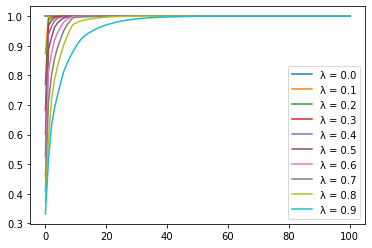

In [24]:
# Plot the cumulative variance explained by each eigenvalue for each lambda value
for lambd in np.arange(0, 1, 0.1):
    # Calculate the exponentially weighted covariance matrix for the given value of λ
    covariance = ewma_covariance(returns, lambd)
    
    # Perform PCA on the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(covariance)
    
    # Sort the eigenvalues and eigenvectors in decreasing order
    eigenvalues = eigenvalues[::-1]
    eigenvectors = eigenvectors[:, ::-1]
    
    # Calculate the cumulative variance explained by each eigenvalue
    explained_variance = np.cumsum(eigenvalues) / np.sum(eigenvalues)
    
    # Plot the cumulative variance explained
    plt.plot(explained_variance, label=f"λ = {lambd:.1f}")

# Add a legend to the plot
plt.legend()

# Show the plot
plt.show()

# Problem 2

In [25]:
def chol_pd(a):
    n = a.shape[0]
    root = np.zeros((n, n))

    for j in range(n):
        s = 0.0
        if j > 0:
            s = np.dot(root[j, :j-1], root[j, :j-1])
        
        root[j, j] = np.sqrt(a[j, j] - s)
        
        ir = 1.0 / root[j, j]
        for i in range(j + 1, n):
            s = np.dot(root[i, :j-1], root[j, :j-1])
            root[i, j] = (a[i, j] - s) * ir
    
    return root


In [26]:
def near_psd(a, epsilon=0.0):
    n = a.shape[0]
    inv_sd = None
    out = np.copy(a)

    if not all(np.isclose(np.diag(out), 1.0)):
        inv_sd = np.diag(1.0 / np.sqrt(np.diag(out)))
        out = np.dot(np.dot(inv_sd, out), inv_sd)

    vals, vecs = np.linalg.eig(out)
    vals = np.maximum(vals, epsilon)
    t = 1.0 / np.dot(vecs**2, vals)
    t = np.diag(np.sqrt(t))
    l = np.diag(np.sqrt(vals))
    b = np.dot(np.dot(t, vecs), l)
    out = np.dot(b, b.T)

    if inv_sd is not None:
        inv_sd = np.diag(1.0 / np.diag(inv_sd))
        out = np.dot(np.dot(inv_sd, out), inv_sd)
    
    return out


In [29]:
def highams(a, epsilon=0.0):
    n = a.shape[0]
    t = np.eye(n) * epsilon
    a_new = a + t
    eigvals, eigvecs = eigh(a_new)
    for i in range(n):
        if eigvals[i] < 0:
            eigvals[i] = epsilon
    return eigvecs.dot(np.diag(eigvals)).dot(eigvecs.T)

In [31]:
n = 500
sigma = np.full((n, n), 0.9)
for i in range(n):
    sigma[i, i] = 1.0
sigma[0, 1] = 0.7357
sigma[1, 0] = 0.7357

In [32]:
start = time.time()
fixed_near_psd = near_psd(sigma)
end = time.time()
print("Time for near_psd:", end - start)

start = time.time()
fixed_highams = highams(sigma)
end = time.time()
print("Time for highams:", end - start)

print("Frobenius norm difference (near_psd vs. highams):", np.linalg.norm(fixed_near_psd - fixed_highams))


Time for near_psd: 0.245650053024292
Time for highams: 3.5467357635498047
Frobenius norm difference (near_psd vs. highams): 37.57492421720327


# Problem 3

In [74]:
def multivariate_normal_simulation(mean, cov, n=1, pca=False, explained_variance=0.95):
    """
    Generate random samples from multivariate normal distribution

    Parameters:
        mean: numpy array, shape (d,)
            Mean of the multivariate normal distribution.
        cov: numpy array, shape (d, d)
            Covariance matrix of the multivariate normal distribution.
        n: int, optional (default=1)
            Number of samples to generate.
        pca: bool, optional (default=False)
            If True, use PCA to reduce the dimension of the covariance matrix to the minimum
            necessary to explain the specified variance.
        explained_variance: float, optional (default=0.95)
            Proportion of variance to be explained by the principal components,
            if pca=True. Must be between 0 and 1.

    Returns:
        samples: numpy array, shape (n, d)
            Random samples from the multivariate normal distribution.
    """
    d = mean.shape[0]
    if pca:
        eigen_values, eigen_vectors = eigh(cov)
        eigen_values = np.flip(eigen_values)
        eigen_vectors = np.fliplr(eigen_vectors)

        cumulative_variance = np.cumsum(eigen_values) / np.sum(eigen_values)
        num_components = np.argmax(cumulative_variance >= explained_variance) + 1

        eigen_vectors = eigen_vectors[:, :num_components]
        cov = eigen_vectors @ np.diag(eigen_values[:num_components]) @ eigen_vectors.T

    L = cholesky(cov, lower=True)
    mean = np.array(mean).reshape(-1, 1)
    samples = mean + (L @ np.random.normal(size=(d, n)))
    samples = samples.T

    return samples

In [75]:
def generate_correlation_matrix(data, method='pearson'):
    """
    Generate a correlation matrix from a dataset

    Parameters:
        data: numpy array, shape (n, d)
            Input dataset.
        method: str, optional (default='pearson')
            Correlation method to use. Supported methods are 'pearson' (standard Pearson correlation)
            and 'ew' (exponentially weighted).

    Returns:
        correlation_matrix: numpy array, shape (d, d)
            Correlation matrix of the input dataset.
    """
    if method == 'pearson':
        correlation_matrix = np.corrcoef(data, rowvar=False)
    elif method == 'ew':
        lambda_ = 0.97
        n = data.shape[0]
        d = data.shape[1]
        covariance_matrix = np.zeros((d, d))
        for i in range(d):
            for j in range(d):
                weighted_sum = 0
                for k in range(n):
                    weighted_sum += lambda_ ** (n - k - 1) * data[k, i] * data[k, j]
                covariance_matrix[i, j] = (1 - lambda_ ** n) / (1 - lambda_) * weighted_sum
        correlation_matrix = covariance_matrix / np.sqrt(np.diag(covariance_matrix))[:, None]
        correlation_matrix /= np.sqrt(np.diag(covariance_matrix))[None, :]
    else:
        raise ValueError(f"Invalid correlation method: {method}")

    return correlation_matrix

In [76]:
def generate_variance_vector(data, method='pearson'):
    """
    Generate a variance vector from a dataset

    Parameters:
        data: numpy array, shape (n, d)
            Input dataset.
        method: str, optional (default='pearson')
            Variance method to use. Supported methods are 'pearson' (standard variance)
            and 'ew' (exponentially weighted).

    Returns:
        variance_vector: numpy array, shape (d,)
            Variance vector of the input dataset.
    """
    if method == 'pearson':
        variance_vector = np.var(data, axis=0)
    elif method == 'ew':
        lambda_ = 0.97
        n = data.shape[0]
        d = data.shape[1]
        variance_vector = np.zeros(d)
        for i in range(d):
            weighted_sum = 0
            for k in range(n):
                weighted_sum += lambda_ ** (n - k - 1) * data[k, i] ** 2
            variance_vector[i] = (1 - lambda_ ** n) / (1 - lambda_) * weighted_sum
    else:
        raise ValueError(f"Invalid variance method: {method}")

    return variance_vector

In [77]:
def generate_covariance_matrix(data, correlation_method, variance_method):
    """
    Generate a covariance matrix from a dataset

    Parameters:
        data: numpy array, shape (n, d)
            Input dataset.
        correlation_method: str, optional (default='pearson')
            Correlation method to use. Supported methods are 'pearson' (standard Pearson correlation)
            and 'ew' (exponentially weighted).
        variance_method: str, optional (default='pearson')
            Variance method to use. Supported methods are 'pearson' (standard variance)
            and 'ew' (exponentially weighted).

    Returns:
        covariance_matrix: numpy array, shape (d, d)
            Covariance matrix of the input dataset.
    """
    correlation_matrix = generate_correlation_matrix(data, method=correlation_method)
    variance_vector = generate_variance_vector(data, method=variance_method)
    covariance_matrix = np.outer(variance_vector, variance_vector) * correlation_matrix
    return covariance_matrix

In [78]:
def simulate_direct(covariance_matrix, n_samples=25000):
    mean = np.zeros(covariance_matrix.shape[0])
    return np.random.multivariate_normal(mean, covariance_matrix, size=n_samples)


In [79]:
def simulate_pca(data, covariance_matrix, explained_variance=1.0):
    eigenvalues, eigenvectors = eigh(covariance_matrix)
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    n_components = int(explained_variance * data.shape[1])
    eigenvectors = eigenvectors[:, :n_components]

    mean = np.mean(data, axis=0)
    data_centered = data - mean
    simulated_data = np.dot(data_centered, eigenvectors)
    simulated_data = np.dot(simulated_data, eigenvectors.T)
    simulated_data = simulated_data + mean

    return simulated_data

In [80]:
def frobenius_norm(A, B):
    return np.linalg.norm(A - B, ord='fro')

In [81]:
if __name__ == '__main__':
    data = pd.read_csv('DailyReturn.csv')
    data = data.iloc[:, 1:]
    data = array(data)
    # Generate covariance matrix using Pearson correlation and variance
    covariance_matrix_1 = generate_covariance_matrix(data, 'pearson', 'pearson')
    print(covariance_matrix_1)

    # Generate covariance matrix using Pearson correlation and exponentially weighted variance
    covariance_matrix_2 = generate_covariance_matrix(data, 'pearson', 'ew')
    print(covariance_matrix_2)

    # Generate covariance matrix using exponentially weighted correlation and variance
    covariance_matrix_3 = generate_covariance_matrix(data, 'ew', 'pearson')
    print(covariance_matrix_3)

    # Generate covariance matrix using exponentially weighted correlation and variance
    covariance_matrix_4 = generate_covariance_matrix(data, 'ew', 'ew')
    print(covariance_matrix_4)

    # Simulate using direct simulation
    start_time = time.time()
    simulated_direct_1 = simulate_direct(covariance_matrix_1)
    print("Direct simulation (covariance matrix 1) time:", time.time() - start_time)

    start_time = time.time()
    simulated_direct_2 = simulate_direct(covariance_matrix_2)
    print("Direct simulation (covariance matrix 2) time:", time.time() - start_time)

    start_time = time.time()
    simulated_direct_3 = simulate_direct(covariance_matrix_3)
    print("Direct simulation (covariance matrix 3) time:", time.time() - start_time)

    start_time = time.time()
    simulated_direct_4 = simulate_direct(covariance_matrix_4)
    print("Direct simulation (covariance matrix 4) time:", time.time() - start_time)

    # Simulate using PCA with 100% explained variance
    start_time = time.time()
    simulated_pca_100_1 = simulate_pca(data, covariance_matrix_1, explained_variance=1.0)
    print("PCA simulation (100% explained variance, covariance matrix 1) time:", time.time() - start_time)

    start_time = time.time()
    simulated_pca_100_2 = simulate_pca(data, covariance_matrix_2, explained_variance=1.0)
    print("PCA simulation (100% explained variance, covariance matrix 2) time:", time.time() - start_time)

    start_time = time.time()
    simulated_pca_100_3 = simulate_pca(data, covariance_matrix_3, explained_variance=1.0)
    print("PCA simulation (100% explained variance, covariance matrix 3) time:", time.time() - start_time)

    start_time = time.time()
    simulated_pca_100_4 = simulate_pca(data, covariance_matrix_4, explained_variance=1.0)
    print("PCA simulation (100% explained variance, covariance matrix 4) time:", time.time() - start_time)

    # Simulate using PCA with 75% explained variance
    start_time = time.time()
    simulated_pca_75_1 = simulate_pca(data, covariance_matrix_1, explained_variance=0.75)
    print("PCA simulation (75% explained variance, covariance matrix 1) time:", time.time() - start_time)

    start_time = time.time()
    simulated_pca_75_2 = simulate_pca(data, covariance_matrix_2, explained_variance=0.75)
    print("PCA simulation (75% explained variance, covariance matrix 2) time:", time.time() - start_time)

    start_time = time.time()
    simulated_pca_75_3 = simulate_pca(data, covariance_matrix_3, explained_variance=0.75)
    print("PCA simulation (75% explained variance, covariance matrix 3) time:", time.time() - start_time)

    start_time = time.time()
    simulated_pca_75_4 = simulate_pca(data, covariance_matrix_4, explained_variance=0.75)
    print("PCA simulation (75% explained variance, covariance matrix 4) time:", time.time() - start_time)

    # Simulate using PCA with 50% explained variance
    start_time = time.time()
    simulated_pca_50_1 = simulate_pca(data, covariance_matrix_1, explained_variance=0.50)
    print("PCA simulation (50% explained variance, covariance matrix 1) time:", time.time() - start_time)

    start_time = time.time()
    simulated_pca_50_2 = simulate_pca(data, covariance_matrix_2, explained_variance=0.50)
    print("PCA simulation (50% explained variance, covariance matrix 2) time:", time.time() - start_time)

    start_time = time.time()
    simulated_pca_50_3 = simulate_pca(data, covariance_matrix_3, explained_variance=0.50)
    print("PCA simulation (50% explained variance, covariance matrix 3) time:", time.time() - start_time)

    start_time = time.time()
    simulated_pca_50_4 = simulate_pca(data, covariance_matrix_4, explained_variance=0.50)
    print("PCA simulation (50% explained variance, covariance matrix 4) time:", time.time() - start_time)

    # Calculate the covariance of the simulated values
    simulated_covariance_direct_1 = np.cov(simulated_direct_1, rowvar=False)
    simulated_covariance_direct_2 = np.cov(simulated_direct_2, rowvar=False)
    simulated_covariance_direct_3 = np.cov(simulated_direct_3, rowvar=False)
    simulated_covariance_direct_4 = np.cov(simulated_direct_4, rowvar=False)

    simulated_covariance_pca_100_1 = np.cov(simulated_pca_100_1, rowvar=False)
    simulated_covariance_pca_100_2 = np.cov(simulated_pca_100_2, rowvar=False)
    simulated_covariance_pca_100_3 = np.cov(simulated_pca_100_3, rowvar=False)
    simulated_covariance_pca_100_4 = np.cov(simulated_pca_100_4, rowvar=False)

    simulated_covariance_pca_75_1 = np.cov(simulated_pca_75_1, rowvar=False)
    simulated_covariance_pca_75_2 = np.cov(simulated_pca_75_2, rowvar=False)
    simulated_covariance_pca_75_3 = np.cov(simulated_pca_75_3, rowvar=False)
    simulated_covariance_pca_75_4 = np.cov(simulated_pca_75_4, rowvar=False)

    simulated_covariance_pca_50_1 = np.cov(simulated_pca_50_1, rowvar=False)
    simulated_covariance_pca_50_2 = np.cov(simulated_pca_50_2, rowvar=False)
    simulated_covariance_pca_50_3 = np.cov(simulated_pca_50_3, rowvar=False)
    simulated_covariance_pca_50_4 = np.cov(simulated_pca_50_4, rowvar=False)

    frobenius_direct_1 = np.linalg.norm(simulated_covariance_direct_1 - covariance_matrix_1, ord='fro')
    frobenius_direct_2 = np.linalg.norm(simulated_covariance_direct_2 - covariance_matrix_2, ord='fro')
    frobenius_direct_3 = np.linalg.norm(simulated_covariance_direct_3 - covariance_matrix_3, ord='fro')
    frobenius_direct_4 = np.linalg.norm(simulated_covariance_direct_4 - covariance_matrix_4, ord='fro')

    frobenius_pca_100_1 = np.linalg.norm(simulated_covariance_pca_100_1 - covariance_matrix_1, ord='fro')
    frobenius_pca_100_2 = np.linalg.norm(simulated_covariance_pca_100_2 - covariance_matrix_2, ord='fro')
    frobenius_pca_100_3 = np.linalg.norm(simulated_covariance_pca_100_3 - covariance_matrix_3, ord='fro')
    frobenius_pca_100_4 = np.linalg.norm(simulated_covariance_pca_100_4 - covariance_matrix_4, ord='fro')

    frobenius_pca_75_1 = np.linalg.norm(simulated_covariance_pca_75_1 - covariance_matrix_1, ord='fro')
    frobenius_pca_75_2 = np.linalg.norm(simulated_covariance_pca_75_2 - covariance_matrix_2, ord='fro')
    frobenius_pca_75_3 = np.linalg.norm(simulated_covariance_pca_75_3 - covariance_matrix_3, ord='fro')
    frobenius_pca_75_4 = np.linalg.norm(simulated_covariance_pca_75_4 - covariance_matrix_4, ord='fro')

    frobenius_pca_50_1 = np.linalg.norm(simulated_covariance_pca_50_1 - covariance_matrix_1, ord='fro')
    frobenius_pca_50_2 = np.linalg.norm(simulated_covariance_pca_50_2 - covariance_matrix_2, ord='fro')
    frobenius_pca_50_3 = np.linalg.norm(simulated_covariance_pca_50_3 - covariance_matrix_3, ord='fro')
    frobenius_pca_50_4 = np.linalg.norm(simulated_covariance_pca_50_4 - covariance_matrix_4, ord='fro')

    print("Frobenius norm (direct simulation, covariance matrix 1):", frobenius_direct_1)
    print("Frobenius norm (direct simulation, covariance matrix 2):", frobenius_direct_2)
    print("Frobenius norm (direct simulation, covariance matrix 3):", frobenius_direct_3)
    print("Frobenius norm (direct simulation, covariance matrix 4):", frobenius_direct_4)

    print("Frobenius norm (PCA simulation, 100% explained variance, covariance matrix 1):", frobenius_pca_100_1)
    print("Frobenius norm (PCA simulation, 100% explained variance, covariance matrix 2):", frobenius_pca_100_2)
    print("Frobenius norm (PCA simulation, 100% explained variance, covariance matrix 3):", frobenius_pca_100_3)
    print("Frobenius norm (PCA simulation, 100% explained variance, covariance matrix 4):", frobenius_pca_100_4)

    print("Frobenius norm (PCA simulation, 75% explained variance, covariance matrix 1):", frobenius_pca_75_1)
    print("Frobenius norm (PCA simulation, 75% explained variance, covariance matrix 2):", frobenius_pca_75_2)
    print("Frobenius norm (PCA simulation, 75% explained variance, covariance matrix 3):", frobenius_pca_75_3)
    print("Frobenius norm (PCA simulation, 75% explained variance, covariance matrix 4):", frobenius_pca_75_4)

    print("Frobenius norm (PCA simulation, 50% explained variance, covariance matrix 1):", frobenius_pca_50_1)
    print("Frobenius norm (PCA simulation, 50% explained variance, covariance matrix 2):", frobenius_pca_50_2)
    print("Frobenius norm (PCA simulation, 50% explained variance, covariance matrix 3):", frobenius_pca_50_3)
    print("Frobenius norm (PCA simulation, 50% explained variance, covariance matrix 4):", frobenius_pca_50_4)


[[5.95185891e-09 1.26123779e-08 1.38105872e-08 ... 2.78324872e-08
  1.28160130e-08 1.21476180e-08]
 [1.26123779e-08 6.40928149e-08 3.85791502e-08 ... 3.91287404e-08
  1.17429246e-08 2.02571970e-08]
 [1.38105872e-08 3.85791502e-08 6.27769339e-08 ... 2.97894763e-08
  6.68260570e-09 1.69090213e-08]
 ...
 [2.78324872e-08 3.91287404e-08 2.97894763e-08 ... 5.14850739e-07
  1.07064660e-07 8.45471204e-08]
 [1.28160130e-08 1.17429246e-08 6.68260570e-09 ... 1.07064660e-07
  8.78106776e-08 2.62174160e-08]
 [1.21476180e-08 2.02571970e-08 1.69090213e-08 ... 8.45471204e-08
  2.62174160e-08 7.44218439e-08]]
[[0.00431465 0.00900131 0.01065544 ... 0.01937871 0.00907114 0.00769928]
 [0.00900131 0.04503337 0.02930407 ... 0.02682161 0.00818279 0.01264022]
 [0.01065544 0.02930407 0.05154964 ... 0.02207507 0.00503409 0.01140628]
 ...
 [0.01937871 0.02682161 0.02207507 ... 0.34429787 0.07278392 0.05146807]
 [0.00907114 0.00818279 0.00503409 ... 0.07278392 0.06068382 0.01622427]
 [0.00769928 0.01264022 0.0114